# EasyOCR - Evaluation - 02 / 01- Preprocessing mit CLAHE

In diesem notebook wird ein zweiter Ansatz des Preprocessing ausprobiert mit CLAHE (Contrast Limited Adaptive Histogram Equalization)

In einem iterativen Prozess wird das Bild vorverarbeitet und dann jeweils mittels EasyOCR Text extrahiert, der OCR-Output je Preprocessing Durchlauf wird am Ende nach Position im Bild-Layout (Bounding-Box) gemergt.

---
#### Test auf einzelnen Bildern

In [6]:
# Test von Varianten von Funktionen des Preprocessing "process_image" "process_image2" "process_image_tresh"
import cv2
import numpy as np
from easyocr import Reader

# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Aggressive Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.2, 1.8, 2.5]       # Kontrast
    betas = [-80, 0, 50, 100]           # Helligkeit

    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR + Confidence-Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge-Ergebnisse: nach BoundingBox-Mittelpunkt clustern (einfach, aber effektiv)
def merge_results(all_results, iou_thresh=0.3):
    merged = []
    seen = []

    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        if any(np.linalg.norm(np.array(center) - np.array(seen_c)) < 30 for seen_c in seen):
            continue
        seen.append(center)
        merged.append((text, conf))
    
    return merged

# 4.1 nur zeilen mergen mit hoher confidence
def merge_results2(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# 4.2 merge mit treshold um schlechtere Ergebnisse nicht auszugeben
def merge_results_tresh(all_results, distance_thresh=30, conf_thresh=0.5):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res

        # ➤ Confidence-Filter
        if conf < conf_thresh:
            continue

        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

##########################################################
# 5. Main
def process_image(image_path):
    reader = Reader(['de'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf in merged_texts:
        print(f"{conf:.2f} -> {text}")

# 5.1 mit merge2 kombiniert
def process_image2(image_path):
    reader = Reader(['de'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results2(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf, _ in merged_texts: # Unterstrich für dritten parameter box, der soll nicht ausgegeben werden, wird ignoriert
        print(f"{conf:.2f} -> {text}")


# 5.2 mit merge mit treshold kombiniert
def process_image_tresh(image_path):
    reader = Reader(['de'])
    image = cv2.imread(image_path)
    
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)
    
    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        print(f"[{desc}] erkannte Texte: {len(results)}")
        all_results.extend(results)
    
    merged_texts = merge_results_tresh(all_results)
    print(f"\n🎯 Gesamterkannte (gefilterte + gemergte) Texte: {len(merged_texts)}\n")
    for text, conf, _ in merged_texts: # Unterstrich für dritten parameter box, der soll nicht ausgegeben werden, wird ignoriert
        print(f"{conf:.2f} -> {text}")





In [82]:

process_image2("../../data/images/insta_images/0001.jpg")

[alpha=0.8, beta=-80] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=50] erkannte Texte: 6
[alpha=0.8, beta=100] erkannte Texte: 8
[alpha=1.2, beta=-80] erkannte Texte: 6
[alpha=1.2, beta=0] erkannte Texte: 5
[alpha=1.2, beta=50] erkannte Texte: 7
[alpha=1.2, beta=100] erkannte Texte: 3
[alpha=1.8, beta=-80] erkannte Texte: 7
[alpha=1.8, beta=0] erkannte Texte: 6
[alpha=1.8, beta=50] erkannte Texte: 5
[alpha=1.8, beta=100] erkannte Texte: 3
[alpha=2.5, beta=-80] erkannte Texte: 7
[alpha=2.5, beta=0] erkannte Texte: 4
[alpha=2.5, beta=50] erkannte Texte: 4
[alpha=2.5, beta=100] erkannte Texte: 2

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 12

1.00 -> SPRACHCAFE
0.93 -> WEIHNACHTSFEIER
0.99 -> DIENSTAG 21,12
0.91 -> OLOF-PALME ZENTRUM
1.00 -> 19 UHR
0.73 -> WIR FREUEN UnS AUF EUCH!
1.00 -> SP
1.00 -> CHCAFE
0.97 -> WEI
0.76 -> GHTSFEIER
0.70 -> CHCA
0.50 -> HTSFFFR


In [8]:
process_image("../../data/images/insta_images/0046.jpeg")

[alpha=0.8, beta=-80] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=50] erkannte Texte: 4
[alpha=0.8, beta=100] erkannte Texte: 2
[alpha=1.2, beta=-80] erkannte Texte: 5
[alpha=1.2, beta=0] erkannte Texte: 4
[alpha=1.2, beta=50] erkannte Texte: 3
[alpha=1.2, beta=100] erkannte Texte: 2
[alpha=1.8, beta=-80] erkannte Texte: 4
[alpha=1.8, beta=0] erkannte Texte: 4
[alpha=1.8, beta=50] erkannte Texte: 3
[alpha=1.8, beta=100] erkannte Texte: 2
[alpha=2.5, beta=-80] erkannte Texte: 3
[alpha=2.5, beta=0] erkannte Texte: 2
[alpha=2.5, beta=50] erkannte Texte: 2
[alpha=2.5, beta=100] erkannte Texte: 3

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 13

0.99 -> 248
0.73 -> 01. MÄRZ 2025
0.88 -> Lineuf
0.48 -> Ketohup
0.48 -> Breakbeat)
0.43 -> (fio7
0.86 -> Die beste (nicht)Karnevals
0.74 -> Kostüm Party Berlins
0.98 -> Berlins
0.44 -> Pojektraum
0.90 -> 218
0.64 -> T
1.00 -> 8


In [2]:
process_image2("../../data/images/insta_images/0046.jpeg")

[alpha=0.8, beta=-80] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=50] erkannte Texte: 4
[alpha=0.8, beta=100] erkannte Texte: 2
[alpha=1.2, beta=-80] erkannte Texte: 5
[alpha=1.2, beta=0] erkannte Texte: 4
[alpha=1.2, beta=50] erkannte Texte: 3
[alpha=1.2, beta=100] erkannte Texte: 2
[alpha=1.8, beta=-80] erkannte Texte: 4
[alpha=1.8, beta=0] erkannte Texte: 4
[alpha=1.8, beta=50] erkannte Texte: 3
[alpha=1.8, beta=100] erkannte Texte: 2
[alpha=2.5, beta=-80] erkannte Texte: 3
[alpha=2.5, beta=0] erkannte Texte: 2
[alpha=2.5, beta=50] erkannte Texte: 2
[alpha=2.5, beta=100] erkannte Texte: 3

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 13

0.99 -> 248
0.80 -> 01. MÄRZ 2025
0.94 -> Lineuf
0.48 -> Ketohup
0.48 -> Breakbeat)
0.43 -> (fio7
0.98 -> Die beste (nicht)Karnevals
0.93 -> Kostüm Party Berlins
0.98 -> Berlins
0.44 -> Pojektraum
0.90 -> 218
0.64 -> T
1.00 -> 8


In [7]:
process_image_tresh("../../data/images/insta_images/0046.jpeg")

[alpha=0.8, beta=-80] erkannte Texte: 6
[alpha=0.8, beta=0] erkannte Texte: 6
[alpha=0.8, beta=50] erkannte Texte: 4
[alpha=0.8, beta=100] erkannte Texte: 2
[alpha=1.2, beta=-80] erkannte Texte: 5
[alpha=1.2, beta=0] erkannte Texte: 4
[alpha=1.2, beta=50] erkannte Texte: 3
[alpha=1.2, beta=100] erkannte Texte: 2
[alpha=1.8, beta=-80] erkannte Texte: 4
[alpha=1.8, beta=0] erkannte Texte: 4
[alpha=1.8, beta=50] erkannte Texte: 3
[alpha=1.8, beta=100] erkannte Texte: 2
[alpha=2.5, beta=-80] erkannte Texte: 3
[alpha=2.5, beta=0] erkannte Texte: 2
[alpha=2.5, beta=50] erkannte Texte: 2
[alpha=2.5, beta=100] erkannte Texte: 3

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 9

0.99 -> 248
0.80 -> 01. MÄRZ 2025
0.94 -> Lineuf
0.98 -> Die beste (nicht)Karnevals
0.93 -> Kostüm Party Berlins
0.98 -> Berlins
0.90 -> 218
0.64 -> T
1.00 -> 8


In [4]:
process_image_tresh("../../data/images/insta_images/0180.jpg")

[alpha=0.8, beta=-80] erkannte Texte: 10
[alpha=0.8, beta=0] erkannte Texte: 11
[alpha=0.8, beta=50] erkannte Texte: 11
[alpha=0.8, beta=100] erkannte Texte: 3
[alpha=1.2, beta=-80] erkannte Texte: 12
[alpha=1.2, beta=0] erkannte Texte: 4
[alpha=1.2, beta=50] erkannte Texte: 3
[alpha=1.2, beta=100] erkannte Texte: 0
[alpha=1.8, beta=-80] erkannte Texte: 3
[alpha=1.8, beta=0] erkannte Texte: 1
[alpha=1.8, beta=50] erkannte Texte: 0
[alpha=1.8, beta=100] erkannte Texte: 0
[alpha=2.5, beta=-80] erkannte Texte: 0
[alpha=2.5, beta=0] erkannte Texte: 0
[alpha=2.5, beta=50] erkannte Texte: 0
[alpha=2.5, beta=100] erkannte Texte: 0

🎯 Gesamterkannte (gefilterte + gemergte) Texte: 20

0.99 -> IS PALESTINE
0.99 -> AFEMINIST
0.97 -> ISSUE?I
0.93 -> ZURVERSCHRANKUNG
1.00 -> VON
1.00 -> (QUEER-)FEMINISMUS
0.87 -> UND ANTISEMITISMUS
0.99 -> & Diskussion mit
0.95 -> Do 19.12.
0.83 -> 19-00 Uhr
0.83 -> Vortrag & Diskussion mit
0.98 -> Cordula Trunk
0.60 -> 4
1.00 -> FEMINIST
0.53 -> ;
1.00 -> Trunk
0.

In [9]:
import easyocr
from easyocr import Reader
reader = easyocr.Reader(['de'])  
result = reader.readtext('../../data/images/insta_images/0180.jpg', detail=0) 
print(result)

['IS PALESTINE', '4', 'FEMINIST', 'ISSUE?!', 'ZUR VERSCHRÄNKUNG', 'VON', '(QUEER-)FEMINISMUS', 'UND ANTISEMITISMUS', 'coaqfPiak', '& Diskussion mit', ';', 'Trunk', '|', 'Do 19.12.', ':', '19:00 Uhr', 'Ä']


---
### Anwendung auf gesamtem Datesatz

In [38]:
# Preprocessing Funktion + Berechnung CER/WER - line-merge:Varinate: es werden nur zeilen mit hoher confidence gemergt

import os
import cv2
import numpy as np
import pandas as pd
from easyocr import Reader
import sys 
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD



# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.2, 1.8, 2.5]
    betas = [-80, 0, 50, 100]
    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR mit Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge nach Bounding-Box-Mittelpunkt
def merge_results(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# Evaluation
def evaluate_ocr_with_metrics(gt_lines, ocr_lines):
    matches = match_gt_to_ocr(gt_lines, ocr_lines)
    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = sum(1 for (_, ocr_idx) in matches if ocr_idx is not None)

    cer_list = []
    wer_list = []

    for gt_idx, ocr_idx in matches:
        gt = gt_lines[gt_idx]
        pred = ocr_lines[ocr_idx] if ocr_idx is not None else ""
        cer_list.append(calculate_cer(gt, pred))
        wer_list.append(calculate_wer(gt, pred))

    mean_cer = sum(cer_list) / total_gt if total_gt else None
    mean_wer = sum(wer_list) / total_gt if total_gt else None

    return {
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": mean_cer,
        "mean_wer": mean_wer
        
    }



# 5. Hauptfunktion für ein Bild
def process_image(image_path, reader):
    image = cv2.imread(image_path)
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)

    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        all_results.extend(results)
    
    merged = merge_results(all_results)
    return [text for text, conf, box in merged]  # ← Nur Texte extrahieren


# 6. Batch-Verarbeitung + CSV Export
def process_folder_with_eval(image_folder, gt_dict, output_csv):
    reader = Reader(['de'])
    results = []

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(image_folder, fname)
        print(f"🔍 Verarbeite: {fname}")
        try:
            ocr_lines = process_image(img_path, reader)  # EasyOCR-Ausgabe
            gt_lines = gt_dict.get(fname, [])

            eval_result = evaluate_ocr_with_metrics(gt_lines, ocr_lines)
            eval_result.update({
                "file_name": fname,
                "ocr_easyocr_clahe": ocr_lines
            })

            results.append(eval_result)

        except Exception as e:
            print(f"⚠️ Fehler bei {fname}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Export abgeschlossen: {output_csv} (Dateien: {len(df)})")




In [39]:
import os
import json
JSON_PATH = "../../data/data_annotated.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

gt_dict = {e["file_name"]: e.get("lines", []) for e in all_data if "file_name" in e}

process_folder_with_eval("../../data/images/insta_images", gt_dict, "../../data/OCR/easyocr/ocr_evaluation_clahe.csv")


🔍 Verarbeite: 0071.jpg
🔍 Verarbeite: 0059.jpg
🔍 Verarbeite: 0111.jpg
🔍 Verarbeite: 0139.jpg
🔍 Verarbeite: 0110.jpg
🔍 Verarbeite: 0104.jpg
🔍 Verarbeite: 0039.jpeg
🔍 Verarbeite: 0064.jpg
🔍 Verarbeite: 0066.jpg
🔍 Verarbeite: 0072.jpg
🔍 Verarbeite: 0099.jpg
🔍 Verarbeite: 0112.jpg
🔍 Verarbeite: 0106.jpg
🔍 Verarbeite: 0113.jpg
🔍 Verarbeite: 0131.jpeg
🔍 Verarbeite: 0127.jpeg
🔍 Verarbeite: 0098.jpg
🔍 Verarbeite: 0170.jpeg
🔍 Verarbeite: 0063.jpg
🔍 Verarbeite: 0117.jpg
🔍 Verarbeite: 0103.jpg
🔍 Verarbeite: 0116.jpg
🔍 Verarbeite: 0018.jpeg
🔍 Verarbeite: 0062.jpg
🔍 Verarbeite: 0074.jpg
🔍 Verarbeite: 0060.jpg
🔍 Verarbeite: 0128.jpg
🔍 Verarbeite: 0100.jpg
🔍 Verarbeite: 0114.jpg
🔍 Verarbeite: 0115.jpg
🔍 Verarbeite: 0101.jpg
🔍 Verarbeite: 0129.jpg
🔍 Verarbeite: 0147.jpeg
🔍 Verarbeite: 0061.jpg
🔍 Verarbeite: 0075.jpg
🔍 Verarbeite: 0049.jpg
🔍 Verarbeite: 0012.jpg
🔍 Verarbeite: 0006.jpg
🔍 Verarbeite: 0210.jpg
🔍 Verarbeite: 0204.jpg
🔍 Verarbeite: 0238.jpg
🔍 Verarbeite: 0166.jpg
🔍 Verarbeite: 0172.jpg
🔍 Ver

In [40]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/ocr_evaluation_clahe.csv")

df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe
0,7,17,4,0.570666,0.809524,0071.jpg,"['Grafir:', 'Siegessävle', 'Stare:', '2020', '..."
1,7,19,2,0.763975,0.750000,0059.jpg,"['n', '8.', 'Sozialraunorientierte', 'HEDY', '..."
2,13,33,11,0.230419,0.282051,0111.jpg,"['50 JAHRE', 'RUMBLE IN THE JUNGLE', 'Podium:'..."
3,8,14,6,0.252193,0.265625,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'KUNDGEB..."
4,5,9,4,0.329697,0.900000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'A1gg WEGBASS..."


### Evaluation - Berechnung CER und WER - zeilenbasiert

In [41]:
df["recognition_rate"] = df["matched_lines"] / df["gt_lines"]

In [42]:
# Durchschnitt berechnen
mean_cer = df["mean_cer"].mean()
mean_wer = df["mean_wer"].mean()
mean_ER = df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.730
CER: 0.326
WER: 0.496


Werte ohne Preprocessing im Vergleich:  
Erkennungsrate: 0.723  
CER: 0.337  
WER: 0.526  

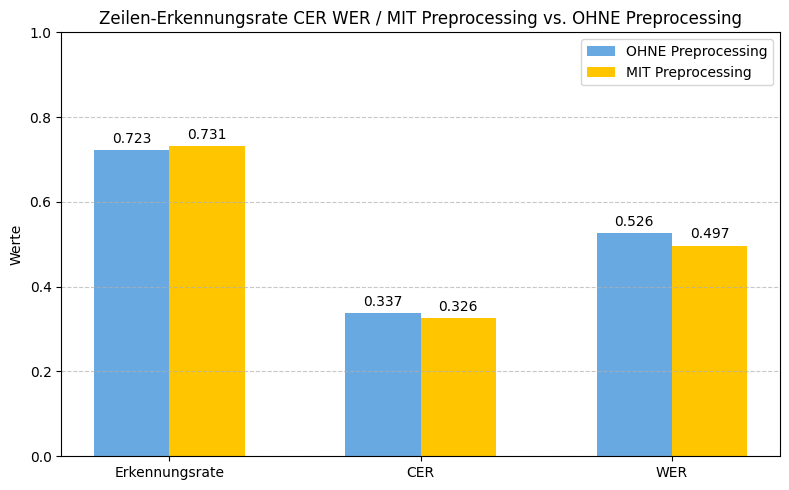

In [15]:
import matplotlib.pyplot as plt

# Deine neuen Werte
kategorien = ['Erkennungsrate', 'CER','WER']
werte_neu = [0.731, 0.326, 0.497]
werte_alt = [0.723, 0.337, 0.526]


# Balkendiagramm nebeneinander
x = range(len(kategorien))
breite = 0.30
fig, ax = plt.subplots(figsize=(8, 5))

bars1 = plt.bar([i - breite/2 for i in x], werte_alt, width=breite, label='OHNE Preprocessing',  color='#69A9E1')
bars2 = plt.bar([i + breite/2 for i in x], werte_neu, width=breite, label='MIT Preprocessing',  color='#FFC600')

ax.set_ylim(0, 1)
plt.xticks(x, kategorien)
plt.ylabel('Werte')
plt.title('Zeilen-Erkennungsrate CER WER / MIT Preprocessing vs. OHNE Preprocessing')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')
plt.show()

In [13]:
import pandas as pd
df_pics = pd.read_csv("../../data/image_data_with_groundtruth.csv")

In [14]:
# Nur relevante Spalten
df_reduced = df_pics[["file_name", "category"]]

merged_df = df.merge(df_reduced, on="file_name", how="left")

merged_df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe,recognition_rate,category
0,7,17,4,0.570666,0.809524,0071.jpg,"['Grafir:', 'Siegessävle', 'Stare:', '2020', '...",0.571429,fancy
1,7,19,2,0.763975,0.750000,0059.jpg,"['n', '8.', 'Sozialraunorientierte', 'HEDY', '...",0.285714,fancy
2,13,33,11,0.230419,0.282051,0111.jpg,"['50 JAHRE', 'RUMBLE IN THE JUNGLE', 'Podium:'...",0.846154,photo
3,8,14,6,0.252193,0.265625,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'KUNDGEB...",0.750000,simple
4,5,9,4,0.329697,0.900000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'A1gg WEGBASS...",0.800000,photo


In [22]:
merged_df.to_csv("../../data/OCR/easyocr/ocr_evaluation_clahe_with_category.csv", index=False)

In [15]:
CER_by_category = merged_df.groupby("category")["mean_cer"].mean() * 100
CER_by_category = CER_by_category.round(2)
CER_by_category = CER_by_category.sort_values(ascending=True)

print(CER_by_category)

category
simple    22.05
skewed    27.83
noisy     31.91
photo     41.89
fancy     44.85
Name: mean_cer, dtype: float64


CER ohne Preprocessing:  
category  
simple    22.30  
skewed    31.64  
noisy     33.40  
photo     41.88  
fancy     45.91  

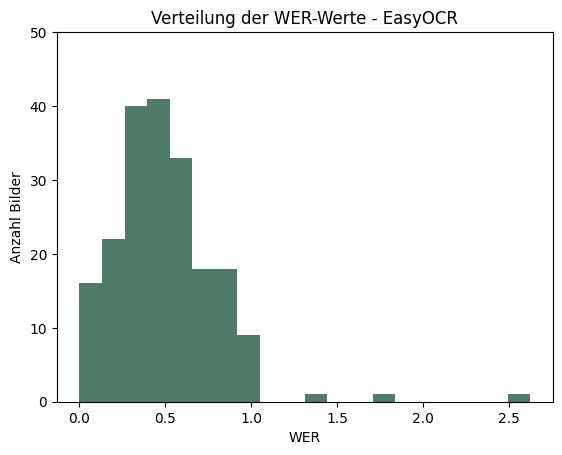

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

wer_values = merged_df["mean_wer"] 

plt.hist(wer_values, bins=20, color='#527a68')
plt.ylim(0, 50)
plt.xlabel('WER')
plt.ylabel('Anzahl Bilder')
plt.title('Verteilung der WER-Werte - EasyOCR')
plt.grid(False)
plt.show()

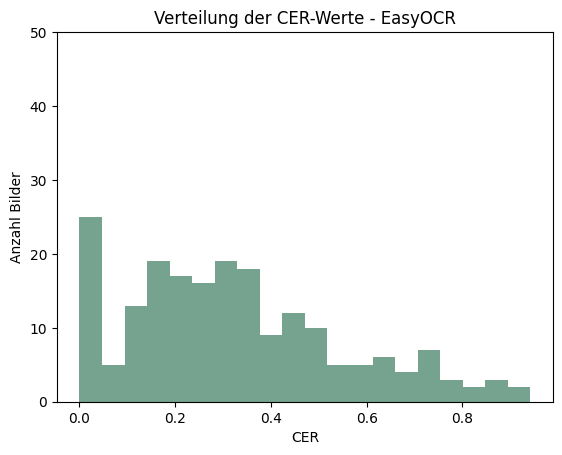

In [18]:
cer_values = df["mean_cer"] 

plt.hist(cer_values, bins=20, color='#76a38f')
plt.ylim(0, 50)
plt.xlabel('CER')
plt.ylabel('Anzahl Bilder')
plt.title('Verteilung der CER-Werte - EasyOCR')
plt.grid(False)
plt.show()

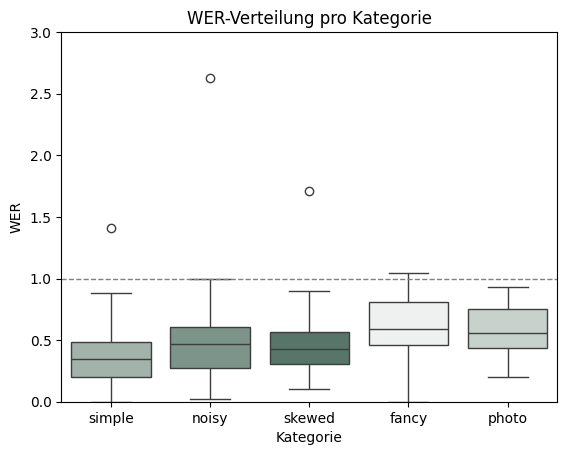

In [23]:
import seaborn as sns
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/ocr_evaluation_clahe_with_category.csv") 

categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']


sns.boxplot(data=df, x='category', y='mean_wer',  hue='category', palette='light:#527a68', order=categories)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('WER-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('WER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

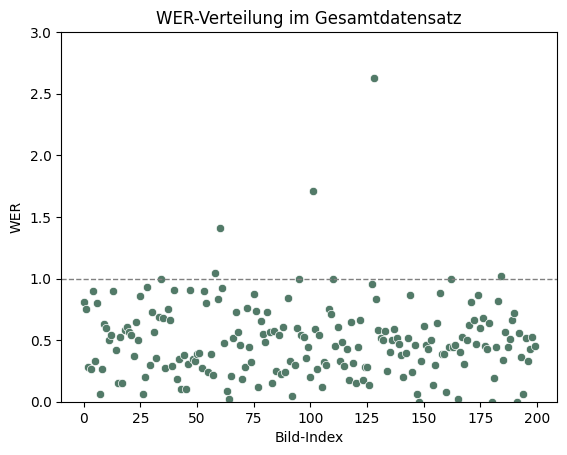

In [24]:
sns.scatterplot(x=range(len(df)), y=df['mean_wer'], color='#527a68')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('WER-Verteilung im Gesamtdatensatz')
plt.xlabel('Bild-Index')
plt.ylabel('WER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

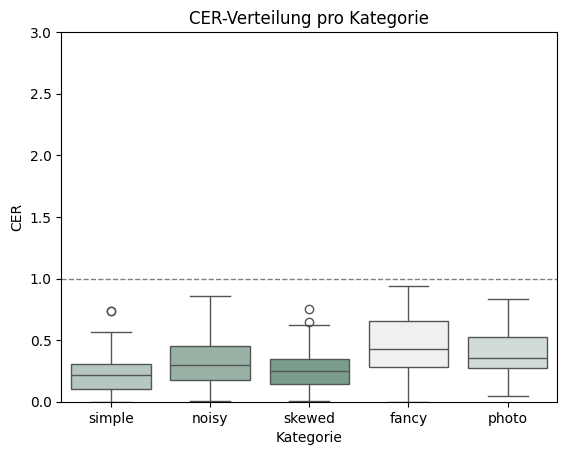

In [25]:
categories = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
sns.boxplot(data=df, x='category', y='mean_cer',  hue='category', palette='light:#76a38f', order=categories)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('CER-Verteilung pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('CER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

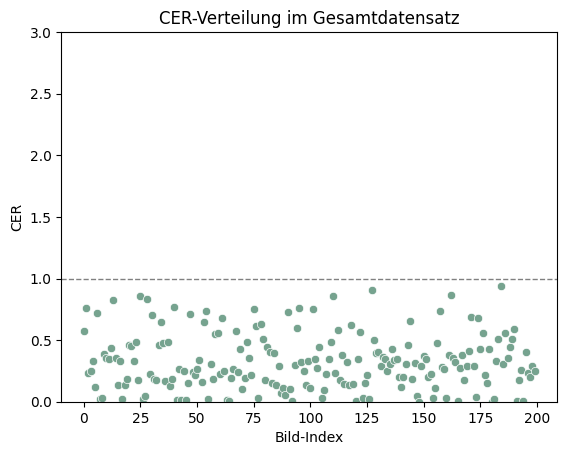

In [26]:
sns.scatterplot(x=range(len(df)), y=df['mean_cer'], color='#76a38f')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.title('CER-Verteilung im Gesamtdatensatz')
plt.xlabel('Bild-Index')
plt.ylabel('CER')
plt.ylim(0, 3)
plt.grid(False)
plt.show()

In [27]:
WER_by_category = merged_df.groupby("category")["mean_wer"].mean() * 100
WER_by_category = WER_by_category.round(2)
WER_by_category = WER_by_category.sort_values(ascending=True)

print(WER_by_category)

category
simple    22.05
skewed    27.83
noisy     31.91
photo     41.89
fancy     44.85
Name: mean_cer, dtype: float64


WER ohne Preprocessing:  
simple    39.13
skewed    51.64
noisy     55.83
fancy     62.73
photo     65.32

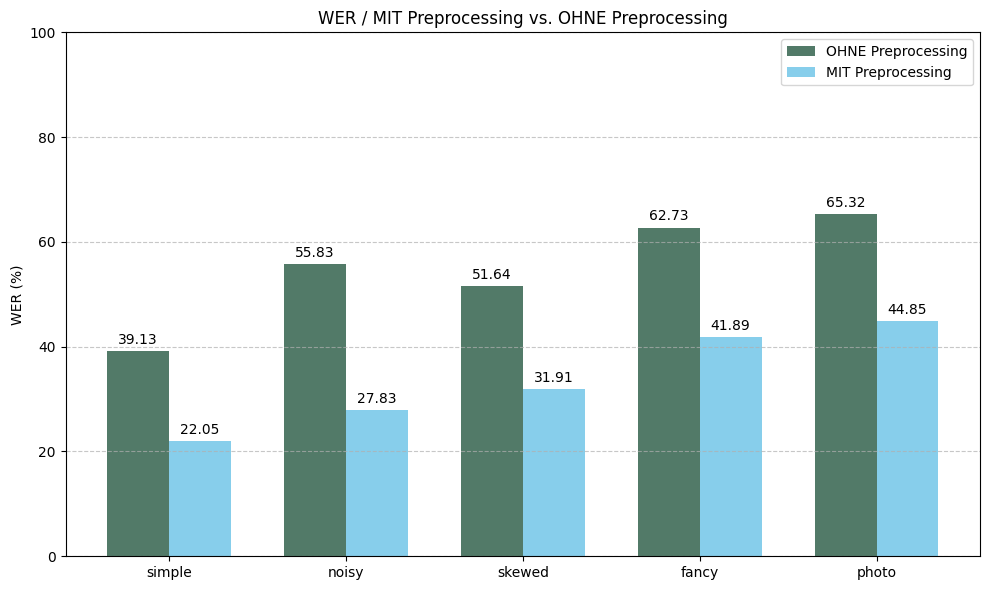

In [43]:
import matplotlib.pyplot as plt

# Deine neuen Werte
kategorien = ['simple', 'noisy','skewed', 'fancy', 'photo']
werte_neu = [22.05, 27.83, 31.91, 41.89, 44.85]
werte_alt = [39.13, 55.83, 51.64, 62.73, 65.32]


# Balkendiagramm nebeneinander
x = range(len(kategorien))
breite = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# color='#FFC600'
bars1 = plt.bar([i - breite/2 for i in x], werte_alt, width=breite, label='OHNE Preprocessing',  color='#527a68')
bars2 = plt.bar([i + breite/2 for i in x], werte_neu, width=breite, label='MIT Preprocessing',  color='skyblue')

ax.set_ylim(0, 100)
plt.xticks(x, kategorien)
plt.ylabel('WER (%)')
plt.title('WER / MIT Preprocessing vs. OHNE Preprocessing')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')
plt.show()

In [60]:
Erkennungsrate_by_category = merged_df.groupby("category")["recognition_rate"].mean() * 100
Erkennungsrate_by_category = Erkennungsrate_by_category.round(2)
Erkennungsrate_by_category = Erkennungsrate_by_category.sort_values(ascending=False)

print(Erkennungsrate_by_category)

category
simple    82.38
skewed    78.49
noisy     73.69
photo     63.71
fancy     61.87
Name: recognition_rate, dtype: float64


Werte ohne Preprocessing:    
simple    82.53  
skewed    74.39  
noisy     72.47  
photo     64.97   
fancy     61.32  

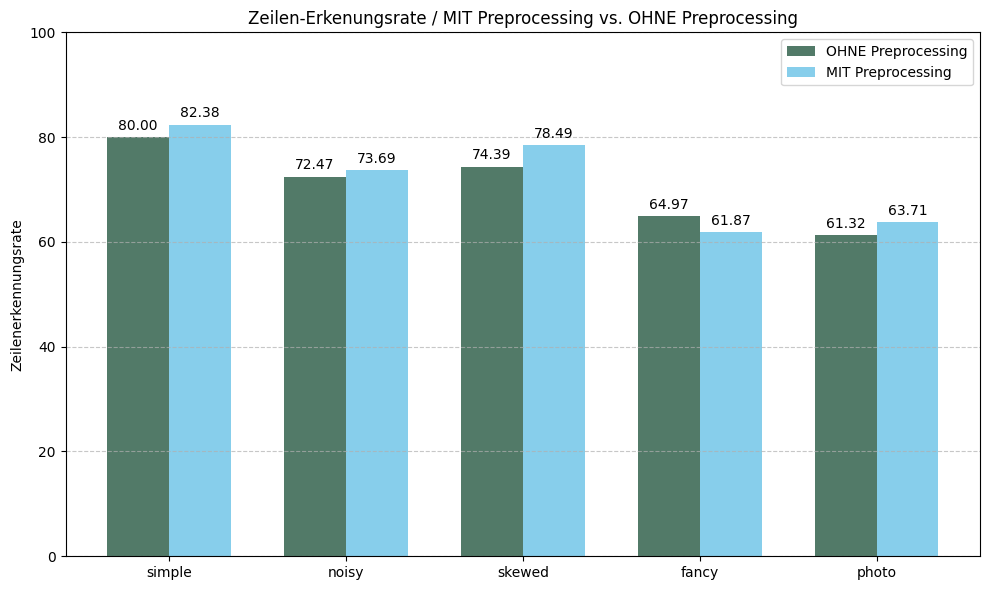

In [45]:
import matplotlib.pyplot as plt

# Deine neuen Werte
kategorien = ['simple', 'noisy','skewed', 'fancy', 'photo']
werte_neu = [82.38, 73.69, 78.49, 61.87, 63.71]
werte_alt = [80.00, 72.47, 74.39, 64.97, 61.32]


# Balkendiagramm nebeneinander
x = range(len(kategorien))
breite = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = plt.bar([i - breite/2 for i in x], werte_alt, width=breite, label='OHNE Preprocessing',  color='#527a68')
bars2 = plt.bar([i + breite/2 for i in x], werte_neu, width=breite, label='MIT Preprocessing',  color='skyblue')

ax.set_ylim(0, 100)
plt.xticks(x, kategorien)
plt.ylabel('Zeilenerkennungsrate')
plt.title('Zeilen-Erkenungsrate / MIT Preprocessing vs. OHNE Preprocessing')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')
plt.show()


---

### Evaluation - Berechnung CER und WER - erkannte Zeilen

In [33]:
import os
import cv2
import numpy as np
import pandas as pd
from easyocr import Reader
import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import cer_for_matching, match_gt_to_ocr, calculate_wer,calculate_cer, CER_THRESHOLD



# 1. CLAHE
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. Varianten
def generate_variants(image):
    variants = []
    alphas = [0.8, 1.2, 1.8, 2.5]
    betas = [-80, 0, 50, 100]
    for alpha in alphas:
        for beta in betas:
            adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
            variants.append((adjusted, f"alpha={alpha}, beta={beta}"))
    return variants

# 3. OCR mit Filter
def run_easyocr(image, reader, conf_thresh=0.4):
    results = reader.readtext(image)
    return [r for r in results if r[2] >= conf_thresh]

# 4. Merge nach Bounding-Box-Mittelpunkt
def merge_results(all_results, distance_thresh=30):
    merged = []
    for res in all_results:
        (tl, tr, br, bl), text, conf = res
        center = ((tl[0] + br[0]) / 2, (tl[1] + br[1]) / 2)

        # Prüfen, ob ein vorhandenes Ergebnis in der Nähe ist
        updated = False
        for i, (existing_text, existing_conf, existing_box) in enumerate(merged):
            existing_center = ((existing_box[0][0] + existing_box[2][0]) / 2,
                               (existing_box[0][1] + existing_box[2][1]) / 2)
            dist = np.linalg.norm(np.array(center) - np.array(existing_center))

            if dist < distance_thresh:
                # Wenn das neue Ergebnis besser ist → ersetzen
                if conf > existing_conf:
                    merged[i] = (text, conf, (tl, tr, br, bl))
                updated = True
                break

        if not updated:
            merged.append((text, conf, (tl, tr, br, bl)))

    return merged

# Evaluation nur gematchte zeilen
def evaluate_ocr_with_metrics_match(gt_lines, ocr_lines):
    matches = match_gt_to_ocr(gt_lines, ocr_lines)
    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = sum(1 for (_, ocr_idx) in matches if ocr_idx is not None)

    matched_cer = []
    matched_wer = []

    for gt_idx, ocr_idx in matches:
        if ocr_idx is not None:
            gt = gt_lines[gt_idx]
            pred = ocr_lines[ocr_idx]
            matched_cer.append(calculate_cer(gt, pred))
            matched_wer.append(calculate_wer(gt, pred))

    mean_cer = sum(matched_cer) / len(matched_cer) if matched_cer else None
    mean_wer = sum(matched_wer) / len(matched_wer) if matched_wer else None

    return {
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": mean_cer,
        "mean_wer": mean_wer
    }




# 5. Hauptfunktion für ein Bild
def process_image(image_path, reader):
    image = cv2.imread(image_path)
    clahe_img = apply_clahe(image)
    variants = generate_variants(clahe_img)

    all_results = []
    for img, desc in variants:
        results = run_easyocr(img, reader)
        all_results.extend(results)
    
    merged = merge_results(all_results)
    return [text for text, conf, box in merged]  # ← Nur Texte extrahieren


# 6. Batch-Verarbeitung + CSV Export
def process_folder_with_eval_match(image_folder, gt_dict, output_csv):
    reader = Reader(['de', 'en'])
    results = []

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(image_folder, fname)
        print(f"🔍 Verarbeite: {fname}")
        try:
            ocr_lines = process_image(img_path, reader)  # EasyOCR-Ausgabe
            gt_lines = gt_dict.get(fname, [])

            eval_result = evaluate_ocr_with_metrics_match(gt_lines, ocr_lines)
            eval_result.update({
                "file_name": fname,
                "ocr_easyocr_clahe": ocr_lines
            })

            results.append(eval_result)

        except Exception as e:
            print(f"⚠️ Fehler bei {fname}: {e}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Export abgeschlossen: {output_csv} (Dateien: {len(df)})")

In [34]:
import os
import json
JSON_PATH = "../../data/data_annotated.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

gt_dict = {e["file_name"]: e.get("lines", []) for e in all_data if "file_name" in e}

process_folder_with_eval_match("../../data/images/insta_images", gt_dict, "../../data/OCR/easyocr/ocr_evaluation_clahe_matched_lines.csv")

🔍 Verarbeite: 0071.jpg
🔍 Verarbeite: 0059.jpg
🔍 Verarbeite: 0111.jpg
🔍 Verarbeite: 0139.jpg
🔍 Verarbeite: 0110.jpg
🔍 Verarbeite: 0104.jpg
🔍 Verarbeite: 0039.jpeg
🔍 Verarbeite: 0064.jpg
🔍 Verarbeite: 0066.jpg
🔍 Verarbeite: 0072.jpg
🔍 Verarbeite: 0099.jpg
🔍 Verarbeite: 0112.jpg
🔍 Verarbeite: 0106.jpg
🔍 Verarbeite: 0113.jpg
🔍 Verarbeite: 0131.jpeg
🔍 Verarbeite: 0127.jpeg
🔍 Verarbeite: 0098.jpg
🔍 Verarbeite: 0170.jpeg
🔍 Verarbeite: 0063.jpg
🔍 Verarbeite: 0117.jpg
🔍 Verarbeite: 0103.jpg
🔍 Verarbeite: 0116.jpg
🔍 Verarbeite: 0018.jpeg
🔍 Verarbeite: 0062.jpg
🔍 Verarbeite: 0074.jpg
🔍 Verarbeite: 0060.jpg
🔍 Verarbeite: 0128.jpg
🔍 Verarbeite: 0100.jpg
🔍 Verarbeite: 0114.jpg
🔍 Verarbeite: 0115.jpg
🔍 Verarbeite: 0101.jpg
🔍 Verarbeite: 0129.jpg
🔍 Verarbeite: 0147.jpeg
🔍 Verarbeite: 0061.jpg
🔍 Verarbeite: 0075.jpg
🔍 Verarbeite: 0049.jpg
🔍 Verarbeite: 0012.jpg
🔍 Verarbeite: 0006.jpg
🔍 Verarbeite: 0210.jpg
🔍 Verarbeite: 0204.jpg
🔍 Verarbeite: 0238.jpg
🔍 Verarbeite: 0166.jpg
🔍 Verarbeite: 0172.jpg
🔍 Ver

In [35]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/ocr_evaluation_clahe_matched_lines.csv")

df.head()

,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,file_name,ocr_easyocr_clahe
0,7,17,4,0.248665,0.666667,0071.jpg,"['Grafir:', 'Siegessävle', 'Stare:', '2020', '..."
1,7,19,2,0.173913,0.125000,0059.jpg,"['n', '8.', 'Sozialraunorientierte', 'HEDY', '..."
2,13,33,11,0.090495,0.151515,0111.jpg,"['50 JAHRE', 'RUMBLE IN THE JUNGLE', 'Podium:'..."
3,8,14,6,0.002924,0.020833,0139.jpg,"['MEHR POLIZEI?', 'NICHTS ZU FEIERN', 'KUNDGEB..."
4,5,9,4,0.162121,0.875000,0110.jpg,"['CLUBS', 'STADT', 'KLIMAKRISE', 'A1gg WEGBASS..."


In [36]:
df["recognition_rate"] = df["matched_lines"] / df["gt_lines"]

In [37]:
# Durchschnitt berechnen
mean_cer = df["mean_cer"].mean()
mean_wer = df["mean_wer"].mean()
mean_ER = df["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.730
CER: 0.089
WER: 0.350


Werte ohne Preprocessing:  
Erkennungsrate: 0.723  
CER: 0.097  
WER: 0.380  

---
### Evaluation - auf Entitäten prüfen

In [72]:
import json
import pandas as pd

JSON_PATH = "../../data/data_annotated.json"
CSV_PATH = "../../data/OCR/ocr_evaluation_clahe_matched_lines.csv"
OUTPUT_PATH = "../../data/OCR/cr_evaluation_clahe_entities.csv"

# JSON & CSV laden
with open(JSON_PATH, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

ocr_df = pd.read_csv(CSV_PATH)

# NaN in 'ocr_text' durch leeren String ersetzen
ocr_df["ocr_easyocr_clahe"] = ocr_df["ocr_easyocr_clahe"].fillna("")

# Alle Labels, die wir tracken wollen
labels_to_track = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

# Ergebnisliste
results = []

for gt_entry in gt_data:
    file_name = gt_entry["file_name"]
    gt_entities = gt_entry.get("entities", [])

    # OCR-Text zur Datei holen
    ocr_row = ocr_df[ocr_df["file_name"] == file_name]
    if ocr_row.empty:
        print(f"OCR-Text für {file_name} nicht gefunden – übersprungen.")
        continue
    ocr_text = ocr_row.iloc[0]["ocr_easyocr_clahe"]

    # Initiale Zähler
    result_row = {"file_name": file_name}
    for label in labels_to_track:
        result_row[f"Anzahl_{label}_gt"] = 0
        result_row[f"Anzahl_{label}_erkannt"] = 0

    erkannte_entitaeten = []
    nicht_erkannte_entitaeten = []

    for ent in gt_entities:
        label = ent["label"]
        text = ent["text"]

        if label not in labels_to_track:
            continue

        # Ground-Truth-Zähler erhöhen
        result_row[f"Anzahl_{label}_gt"] += 1

        # Prüfen, ob Text im OCR vorkommt
        if text in ocr_text:
            result_row[f"Anzahl_{label}_erkannt"] += 1
            erkannte_entitaeten.append(f"[{label}] {text}")
        else:
            nicht_erkannte_entitaeten.append(f"[{label}] {text}")

    # Listen speichern als Strings
    result_row["erkannte_entities"] = "; ".join(erkannte_entitaeten)
    result_row["nicht_erkannte_entities"] = "; ".join(nicht_erkannte_entitaeten)

    results.append(result_row)

# In DataFrame umwandeln und speichern
df_result = pd.DataFrame(results)
df_result.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Auswertung gespeichert in: {OUTPUT_PATH}")

Auswertung gespeichert in: ../../data/OCR/cr_evaluation_clahe_entities.csv


In [73]:
df = pd.read_csv("../../data/OCR/cr_evaluation_clahe_entities.csv")
df.head(1)


,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities
0,0001.jpg,1,1,0,0,2,1,1,1,2,1,[EVENT] WEIHNACHTSFEIER; [DATE] DIENSTAG; [TIM...,[DATE] 21.12.; [LOC] OLOF-PALME ZENTRUM


#### Entitäten Erkennungsrate berechnen

In [74]:
#Funktion berechne_erkennungsraten 
import pandas as pd


def berechne_erkennungsraten(csv_datei):
    # CSV laden
    df = pd.read_csv(csv_datei)

    # Entitäten, für die Erkennungsraten berechnet werden sollen
    entities = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

    # Für jede Entität die Erkennungsrate berechnen
    for ent in entities:
        gt_col = f"Anzahl_{ent}_gt"
        erk_col = f"Anzahl_{ent}_erkannt"
        rate_col = f"Erkennungsrate_{ent}"

        # Division mit Schutz vor 0
        df[rate_col] = df[erk_col] / df[gt_col]
        df[rate_col] = df[rate_col].replace([float("inf"), float("-inf")], 0).fillna(0)

    return df

In [75]:
CSV_PATH = "../../data/OCR/cr_evaluation_clahe_entities.csv"
df_ergebnisse = berechne_erkennungsraten(CSV_PATH)


In [76]:
mean_reg_rate_Event = df_ergebnisse["Erkennungsrate_EVENT"].mean()
mean_reg_rate_Topic = df_ergebnisse["Erkennungsrate_TOPIC"].mean()
mean_reg_rate_Date = df_ergebnisse["Erkennungsrate_DATE"].mean()
mean_reg_rate_Time = df_ergebnisse["Erkennungsrate_TIME"].mean()
mean_reg_rate_Loc = df_ergebnisse["Erkennungsrate_LOC"].mean()

reg_rate_ALL = (mean_reg_rate_Event + mean_reg_rate_Topic + mean_reg_rate_Date + mean_reg_rate_Time + mean_reg_rate_Loc) / 5


print(f"Erkennungsrate gesamt: {reg_rate_ALL:.3f}")
print(f"Erkennungsrate pro Entität:")
print(f"Event: {mean_reg_rate_Event:.3f}")
print(f"Topic: {mean_reg_rate_Topic:.3f}")
print(f"Date: {mean_reg_rate_Date:.3f}")
print(f"Time: {mean_reg_rate_Time:.3f}")
print(f"Loc: {mean_reg_rate_Loc:.3f}")

Erkennungsrate gesamt: 0.474
Erkennungsrate pro Entität:
Event: 0.640
Topic: 0.146
Date: 0.615
Time: 0.310
Loc: 0.657


Werte ohne Preprocessing im Vergleich:
Erkennungsrate gesamt: 0.465
Erkennungsrate pro Entität:
Event: 0.623
Topic: 0.135
Date: 0.597
Time: 0.325
Loc: 0.645


----
### Vergleich der Werte - mit und ohne Preprocessing

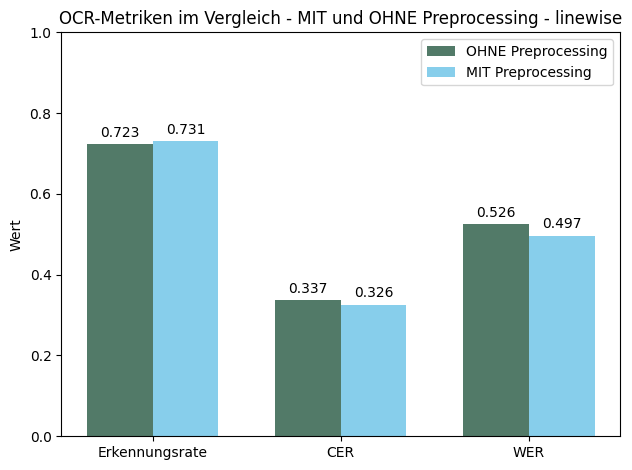

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['Erkennungsrate', 'CER', 'WER']
values_preproc = [0.731, 0.326, 0.497]  
values = [0.723, 0.337, 0.526]  

x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values, width, label='OHNE Preprocessing', color='#527a68')
bars2 = ax.bar(x + width/2, values_preproc, width, label='MIT Preprocessing', color='skyblue')


# Beschriftung
ax.set_ylabel('Wert')
ax.set_title('OCR-Metriken im Vergleich - MIT und OHNE Preprocessing - linewise')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

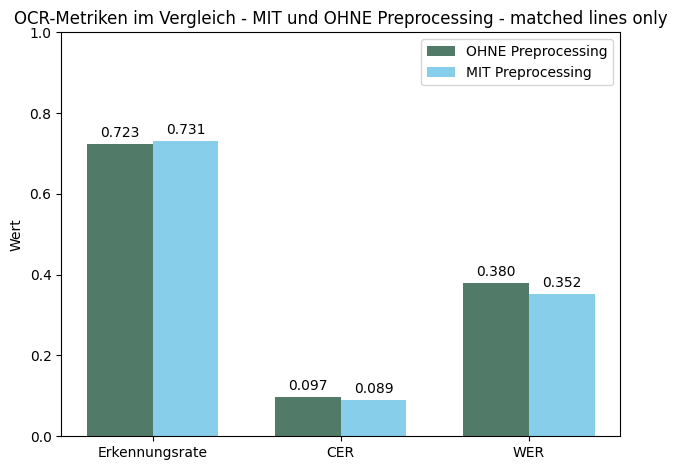

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['Erkennungsrate', 'CER', 'WER']
values_preproc = [0.731, 0.089, 0.352]  
values = [0.723, 0.097, 0.380]  

x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values, width, label='OHNE Preprocessing', color='#527a68')
bars2 = ax.bar(x + width/2, values_preproc, width, label='MIT Preprocessing', color='skyblue')


# Beschriftung
ax.set_ylabel('Wert')
ax.set_title('OCR-Metriken im Vergleich - MIT und OHNE Preprocessing - matched lines only')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

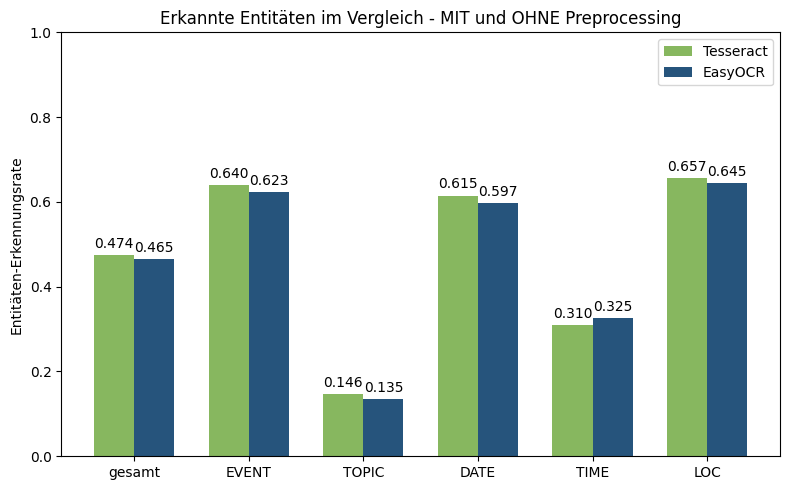

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
metrics = ['gesamt', 'EVENT', 'TOPIC', 'DATE', 'TIME','LOC' ]
mit = [0.474, 0.640, 0.146, 0.615, 0.310, 0.657 ]  
ohne = [0.465, 0.623, 0.135, 0.597, 0.325, 0.645 ]  


x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, mit, width, label='Tesseract', color='#87b75f')
bars2 = ax.bar(x + width/2, ohne, width, label='EasyOCR', color='#26547c')


# Beschriftung
ax.set_ylabel('Entitäten-Erkennungsrate')
ax.set_title('Erkannte Entitäten im Vergleich - MIT und OHNE Preprocessing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()